In [404]:
import pandas as pd
import numpy as np
from tokenize import generate_tokens
xrange = range
from io import StringIO
import matplotlib
import matplotlib.pyplot

In [405]:
# Helper funtions to process an array of strings from a csv

def parts(a):
    """Split a python-tokenizable expression on comma operators"""
    compos = [-1] # compos stores the positions of the relevant commas in the argument string
    compos.extend(t[2][1] for t in generate_tokens(StringIO(a).readline) if t[1] == ',')
    compos.append(len(a))
    return [ a[compos[i]+1:compos[i+1]] for i in xrange(len(compos)-1)]

#coverts to list of strings
def convertType(toConv, makeUpper):
    
    tcs = []
    for tc in toConv:
        tc = tc.replace('[','')
        tc = tc.replace(']','')
        tc = tc.replace('{','')
        tc = tc.replace('}','')
        tc = tc.replace(' \'','')
        tc = tc.replace('\'','')
        tc = tc.replace('@','')
        tc = tc.replace('-','')
        tc = tc.replace('#','')
        chain = parts(tc)
        
        chain2 = []
        for c in chain:
            chain2.append(c) 
        
        #make uppercase if specified
        chain3 = []
        if makeUpper:
            for c in chain2:
                chain3.append(c.upper())
            tcs.append(chain3)
        else:
            tcs.append(chain2)
        
    return np.array(tcs)

def fixDF(df):
    # remove empty columns
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

    # fix all string fields 
    for column in df:
        if (type(df[column][0]) == str):
            df[column] = convertType(df[column], False)
    
    return df 


In [406]:
# load in datasets
# load dataset and fix all string fields 

bills = pd.read_csv("bills_2019.csv")
bills = fixDF(bills)

legislators = pd.read_csv("legislators_2019.csv")
legislators = fixDF(legislators)

relationships = pd.read_csv("matrix_2019.csv")
relationships = fixDF(relationships)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Bill Analysis ###

In [407]:
# 1 Introduced
# 2 Engrossed
# 3 Enrolled
# 4 Passed
# 5 Vetoed

In [408]:
len(bills)

2497

['bill_id', 'bill_number', 'change_hash', 'url', 'status_date', 'status', 'last_action_date', 'last_action', 'title', 'description', 'session_id', 'session_name', 'state_link', 'completed', 'state', 'state_id', 'bill_type', 'bill_type_id', 'bodie', 'body_id', 'current_body', 'current_body_id', 'pending_committee_id', 'progress_event', 'progress_date', 'history_date', 'history_action', 'history_chamber', 'history_chamber_id', 'history_importance', 'sponsor_people_id', 'sponsor_party_id', 'sponsor_party', 'sponsor_role_id', 'sponsor_role', 'sponsor_name', 'sponsor_district', 'sponsor_type_id', 'sponsor_order', 'committee_sponsor', 'votes_roll_call_id', 'votes_date', 'votes_desc', 'votes_yea', 'votes_nay', 'votes_nv', 'votes_absent', 'votes_total', 'votes_passed', 'votes_chamber', 'votes_chamber_id', 'votes_url', 'votes_state_link']
1    1373
3    848 
2    259 
4    17  
Name: status, dtype: int64


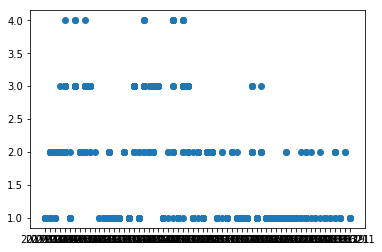

In [409]:
statuses = bills["status"]
print(list(bills))
print(statuses.value_counts())
matplotlib.pyplot.plot_date(bills["status_date"], bills["status"])

In [410]:
sp = bills['sponsor_party']
ps = []
for s in sp:
    ps.append(s[0])
unique, counts = np.unique(ps, return_counts=True)
print(dict(zip(unique, counts)))

{'': 262, 'D': 1672, 'R': 563}


In [411]:
passed_bills = bills[(bills["status"] == 4) | (bills["status"] == 3)]
print(len(passed_bills))

865


In [412]:
print(sum(legislators['primary_sponsored_bills_passed']))

864


In [413]:
pd.set_option('display.max_colwidth', -1)
n = 'Prince Georges County Delegation'
legislatorspg = legislators[legislators['name'] == n]
print(legislatorspg['primary_sponsored_bills'].sort_values())

148    [1168043,  1168000,  1167985,  1168038,  1167998,  1168014,  1168025,  1167966,  1168040,  1168061,  1168012,  1167971,  1168002,  1167994,  1168044,  1168042,  1167980,  1182345,  1182320,  1182323,  1184991,  1196438,  1196983,  1196548,  1209520,  1209526,  1209514,  1217191]
Name: primary_sponsored_bills, dtype: object


In [414]:
print(len(passed_bills))

865


In [415]:
print(len(bills))

2497


In [416]:
print(sum(legislators['primary_sponsored_bills_count']))

2496


In [417]:
bills_list = [1162064, 1164670, 1164690, 1164746, 1168029, 1175010, 1177768, 1180389, 1180322, 1180329, 1180298, 1182344, 1182290, 1184994, 1184933, 1188986, 1188962, 1188644, 1188923, 1188979, 1188629, 1188939, 1188708, 1188757, 1188697, 1188638, 1188680, 1188821, 1188602, 1188842, 1198196]

this_list = bills[bills["bill_id"].isin(bills_list)]
this_list["bill_number"]

1569    SB129
1578    SB138
1579    SB139
1591    SB151
1636    SB196
1708    SB268
1731    SB291
1751    SB311
1768    SB328
1769    SB329
1770    SB330
1794    SB354
1795    SB355
1881    SB441
1882    SB442
1991    SB551
1992    SB552
1993    SB553
2007    SB567
2129    SB689
2130    SB690
2131    SB691
2137    SB697
2176    SB736
2214    SB774
2244    SB804
2249    SB809
2252    SB812
2254    SB814
2257    SB817
2322    SB882
Name: bill_number, dtype: object

In [418]:
print(list(bills))

['bill_id', 'bill_number', 'change_hash', 'url', 'status_date', 'status', 'last_action_date', 'last_action', 'title', 'description', 'session_id', 'session_name', 'state_link', 'completed', 'state', 'state_id', 'bill_type', 'bill_type_id', 'bodie', 'body_id', 'current_body', 'current_body_id', 'pending_committee_id', 'progress_event', 'progress_date', 'history_date', 'history_action', 'history_chamber', 'history_chamber_id', 'history_importance', 'sponsor_people_id', 'sponsor_party_id', 'sponsor_party', 'sponsor_role_id', 'sponsor_role', 'sponsor_name', 'sponsor_district', 'sponsor_type_id', 'sponsor_order', 'committee_sponsor', 'votes_roll_call_id', 'votes_date', 'votes_desc', 'votes_yea', 'votes_nay', 'votes_nv', 'votes_absent', 'votes_total', 'votes_passed', 'votes_chamber', 'votes_chamber_id', 'votes_url', 'votes_state_link']


In [419]:
# find number of cross party co sponsorships

count = 0
all_count = 0
rtd = 0
dtr = 0
rtr = 0
dtd = 0
for index,row in bills.iterrows():
    if (len(row['sponsor_party']) > 1):
        main = row['sponsor_party'][0]
        if (main.strip() == "R" or main.strip() == "D"):
            sps = row['sponsor_party']
            sps = sps[1:]
            for cp in sps:
                if (cp.strip() == "R" or cp.strip() == "D"):
                    all_count = all_count + 1
                    if (cp.strip() != main.strip()):
                        count = count + 1
                        if (cp.strip() == "D"):
                            dtr = dtr + 1
                        if (cp.strip() == "R"):
                            rtd = rtd + 1
                    else:
                        count = count + 1
                        if (cp.strip() == "D"):
                            dtd = dtd + 1
                        if (cp.strip() == "R"):
                            rtr = rtr + 1
print(count)
print(all_count)
print(rtd)
print(dtr)
print(rtr)
print(dtd)

15618
15618
2248
622
2181
10567


In [420]:
for i in bills['']

SyntaxError: invalid syntax (<ipython-input-420-873a1b2f78f7>, line 1)

In [ ]:
# legislators = legislators[["name","party","primary_sponsored_bills_passed","primary_sponsored_bills_count","primary_sponsored_bills_avg","co_sponsored_bills_avg","co_sponsored_bills_count", "co_sponsored_bills_passed", "committee_sponsor","people_id"]]
# legislators = legislators[legislators['committee_sponsor'] != 1]

print(sum(legislators['co_sponsored_bills_count']))

In [ ]:
print(bills['sponsor_party'])

In [ ]:
print(list(legislators))

### Legislator Analysis ###

In [490]:
# Best Primary Bill AVG
sm = legislators[["name","party","primary_sponsored_bills_passed","primary_sponsored_bills_count","primary_sponsored_bills_avg","co_sponsored_bills_avg","co_sponsored_bills_count", "co_sponsored_bills_passed", "committee_sponsor","people_id"]]
sm = sm[sm['committee_sponsor'] != 1]
sm = sm.sort_values(by=['primary_sponsored_bills_avg', 'primary_sponsored_bills_count'], ascending=[False,False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_avg"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_avg"])))
sm.head(50)

mean: 0.3057712884499195
median: 0.26666666666666666


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Melony Griffith,D,13,13,1.000000,0.604167,48,29,0,4664
1,Maggie McIntosh,D,5,5,1.000000,0.434783,69,30,0,4649
2,Jerry Clark,R,4,4,1.000000,0.157143,70,11,0,19026
3,Charles Otto,R,4,4,1.000000,0.138462,65,9,0,12078
4,Heather Bagnall,D,3,3,1.000000,0.571429,105,60,0,20588
5,Jesse Pippy,R,3,3,1.000000,0.310345,29,9,0,20534
6,Andrea Harrison,D,1,1,1.000000,0.488372,43,21,0,21279
7,Brian Chisholm,R,1,1,1.000000,0.373913,115,43,0,20530
8,Jessica Feldmark,D,1,1,1.000000,0.435294,85,37,0,20860
9,Courtney Watson,D,1,1,1.000000,0.440000,50,22,0,20857


In [ ]:
sm.to_csv("legislators_sm_2019.csv")

In [ ]:
# worst Primary Bill AVG
sm = sm.sort_values(by=['primary_sponsored_bills_avg',"primary_sponsored_bills_count"], ascending=[True,False]).reset_index(drop=True)
sm.head(30)

In [493]:
# most primary sponsors passed
sm = sm.sort_values(by=['primary_sponsored_bills_passed'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_passed"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_passed"])))
sm.head(20)

mean: 3.606382978723404
median: 3.0


,name,party,primary_sponsored_bills_passed,primary_sponsored_bills_count,primary_sponsored_bills_avg,co_sponsored_bills_avg,co_sponsored_bills_count,co_sponsored_bills_passed,committee_sponsor,people_id
0,Thomas Miller,D,17,52,0.326923,0.750000,20,15,0,4700
1,Brian Feldman,D,16,22,0.727273,0.573913,115,66,0,4575
2,Michael Busch,D,16,50,0.320000,0.727273,11,8,0,4569
3,Paul Pinsky,D,14,26,0.538462,0.508772,57,29,0,4725
4,Antonio Hayes,D,14,33,0.424242,0.520833,96,50,0,17321
5,Ronald Young,D,13,30,0.433333,0.439394,132,58,0,11711
6,Melony Griffith,D,13,13,1.000000,0.604167,48,29,0,4664
7,William Smith,D,13,40,0.325000,0.496124,129,64,0,17171
8,Benjamin Kramer,D,12,27,0.444444,0.492537,67,33,0,4597
9,Susan Lee,D,12,37,0.324324,0.500000,124,62,0,4626


In [ ]:
# least primary sponsors passed
sm = sm.sort_values(by=['primary_sponsored_bills_passed'], ascending=[True]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_passed"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_passed"])))
sm.head(50)

In [ ]:
print(len(sm))

In [ ]:
# most primary sponsors attempted
sm = sm.sort_values(by=['primary_sponsored_bills_count'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["primary_sponsored_bills_count"])))
print("median: " + str(np.median(sm["primary_sponsored_bills_count"])))
sm.head(30)

In [ ]:
# least primary sponsors attempted
sm = sm.sort_values(by=['primary_sponsored_bills_count'], ascending=[True]).reset_index(drop=True)
sm.head(70)

In [ ]:
# most co sponsors passed
sm = sm.sort_values(by=['co_sponsored_bills_passed'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["co_sponsored_bills_passed"])))
print("median: " + str(np.median(sm["co_sponsored_bills_passed"])))
sm.head(10)

In [ ]:
# least co sponsors passed
sm = sm.sort_values(by=['co_sponsored_bills_passed'], ascending=[True]).reset_index(drop=True)
sm.head(10)

In [ ]:
# AVG co sponsors highest
sm = sm.sort_values(by=['co_sponsored_bills_avg'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["co_sponsored_bills_avg"])))
print("median: " + str(np.median(sm["co_sponsored_bills_avg"])))
sm.head(10)

In [ ]:
# AVG co sponsors lowest
sm = sm.sort_values(by=['co_sponsored_bills_avg'], ascending=[True]).reset_index(drop=True)
sm.head(10)

In [ ]:
# co sponsors count most
sm = sm.sort_values(by=['co_sponsored_bills_count'], ascending=[False]).reset_index(drop=True)
print("mean: " + str(np.mean(sm["co_sponsored_bills_count"])))
print("median: " + str(np.median(sm["co_sponsored_bills_count"])))
sm.head(10)

In [ ]:
# co sponsors count least
sm = sm.sort_values(by=['co_sponsored_bills_count'], ascending=[True]).reset_index(drop=True)
sm.head(10)

In [ ]:
# Split by party

Rdel = sm.loc[sm['party'] == "R"]
Ddel = sm.loc[sm['party'] == "D"]

print("# of rep deligates: " + str(len(Rdel)))
print("# of dem deligates: " + str(len(Ddel)))
print("\n")

# primary counts
print("Rep primary count mean: " + str(np.mean(Rdel["primary_sponsored_bills_count"])))
print("Rep primary count median: " + str(np.median(Rdel["primary_sponsored_bills_count"])))
print("Dem primary count mean: " + str(np.mean(Ddel["primary_sponsored_bills_count"])))
print("Dem primary count median: " + str(np.median(Ddel["primary_sponsored_bills_count"])))
print("\n")

# Primary Bill AVG
print("Rep primary bill avg mean: " + str(np.mean(Rdel["primary_sponsored_bills_avg"])))
print("Rep primary bill avg median: " + str(np.median(Rdel["primary_sponsored_bills_avg"])))
print("Dem primary bill avg mean: " + str(np.mean(Ddel["primary_sponsored_bills_avg"])))
print("Dem primary bill avg median: " + str(np.median(Ddel["primary_sponsored_bills_avg"])))
print("\n")

# Primary Bill AVG
print("Rep primary bills passed mean: " + str(np.mean(Rdel["primary_sponsored_bills_passed"])))
print("Rep primary bills passed median: " + str(np.median(Rdel["primary_sponsored_bills_passed"])))
print("Dem primary bills passed mean: " + str(np.mean(Ddel["primary_sponsored_bills_passed"])))
print("Dem primary bills passed median: " + str(np.median(Ddel["primary_sponsored_bills_passed"])))
print("\n")

### Relationships Analysis ###

In [ ]:
print(list(legislators))

In [471]:
# most cosponsers

print(list(relationships))

relationships = relationships.sort_values(by=['co_bills_total'], ascending=False)
rsm = relationships[["first_name","second_name","co_bills_total", "co_bills_status","co_bills"]]
rsm = rsm.sort_values(by=['co_bills_total'], ascending=False)
rsm.head(40)

['relationship', 'first_name', 'second_name', 'co_bills', 'co_bills_status', 'co_bills_total']


,first_name,second_name,co_bills_total,co_bills_status,co_bills
0,Susan Lee,William Smith,31,"[3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 1, 3, 3, 3, 2, 3, 1, 1, 1, 1]","[1162064, 1164670, 1164690, 1164746, 1168029, 1175010, 1177768, 1180389, 1180322, 1180329, 1180298, 1182344, 1182290, 1184994, 1184933, 1188986, 1188962, 1188644, 1188923, 1188979, 1188629, 1188939, 1188708, 1188757, 1188697, 1188638, 1188680, 1188821, 1188602, 1188842, 1198196]"
1,Kathy Szeliga,Michael Busch,25,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3]","[1147697, 1147689, 1147682, 1147691, 1167661, 1167619, 1167402, 1167640, 1167381, 1167488, 1167467, 1167446, 1167575, 1167997, 1170390, 1170270, 1170178, 1170404, 1170324, 1170465, 1170151, 1188814, 1194036, 1194034, 1243029]"
2,Chris West,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1]","[1147702, 1147694, 1147700, 1147703, 1164762, 1164738, 1164682, 1164686, 1164698, 1164702, 1164630, 1164758, 1164634, 1164742, 1164674, 1164722, 1164718, 1164734, 1164602, 1164694, 1168007, 1188650, 1196639, 1196860]"
6,Adelaide Eckardt,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1]","[1147702, 1147694, 1147700, 1147703, 1164762, 1164738, 1164682, 1164686, 1164698, 1164702, 1164630, 1164758, 1164634, 1164742, 1164674, 1164722, 1164718, 1164734, 1164602, 1164694, 1168007, 1188650, 1196639, 1196860]"
7,Mary Carozza,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1]","[1147702, 1147694, 1147700, 1147703, 1164762, 1164738, 1164682, 1164686, 1164698, 1164702, 1164630, 1164758, 1164634, 1164742, 1164674, 1164722, 1164718, 1164734, 1164602, 1164694, 1168007, 1188650, 1196639, 1196860]"
5,Michael Busch,Ric Metzgar,24,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 3]","[1147697, 1147689, 1147682, 1147691, 1167661, 1167619, 1167402, 1167423, 1167640, 1167381, 1167488, 1167467, 1167446, 1167575, 1167997, 1170390, 1170270, 1170178, 1170404, 1170324, 1170465, 1170151, 1188814, 1243029]"
4,Michael Busch,Nicholaus Kipke,24,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 2, 3]","[1147697, 1147689, 1147682, 1147691, 1167661, 1167619, 1167402, 1167640, 1167381, 1167488, 1167467, 1167446, 1167575, 1167997, 1170390, 1170270, 1170178, 1170404, 1170324, 1170465, 1170151, 1188814, 1188713, 1243029]"
9,Brian Chisholm,Michael Busch,24,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3]","[1147697, 1147689, 1147682, 1147691, 1167661, 1167619, 1167402, 1167640, 1167381, 1167488, 1167467, 1167446, 1167575, 1167997, 1170390, 1170270, 1170178, 1170404, 1170465, 1170151, 1188814, 1194036, 1194034, 1243029]"
8,Jack Bailey,Thomas Miller,24,"[2, 1, 1, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1]","[1147702, 1147694, 1147700, 1147703, 1164762, 1164738, 1164682, 1164686, 1164698, 1164702, 1164630, 1164634, 1164674, 1164722, 1164718, 1164734, 1164602, 1164694, 1168007, 1188650, 1188674, 1196639, 1196860, 1208187]"
3,Jason Gallion,Thomas Miller,24,"[2, 1, 1, 1, 3, 1, 2, 1, 2, 2, 3, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1]","[1147702, 1147694, 1147700, 1147703, 1162264, 1164762, 1164738, 1164682, 1164686, 1164698, 1164702, 1164630, 1164758, 1164634, 1164674, 1164722, 1164718, 1164734, 1164602, 1164694, 1168007, 1188650, 1196639, 1196860]"


In [ ]:
# least cosponsers
print("Reationships with no cosponserships: " + str(len(rsm.loc[rsm['co_bills_total'] == 0])))
print("Reationships with at least 1 cosponsership: " + str(len(rsm.loc[rsm['co_bills_total'] != 0])))

In [ ]:
xt = legislators[legislators['co_sponsored_bills_count'] == 0]
xt.head()

# Create data for network Graphics

In [481]:
nt = legislators[legislators['committee_sponsor'] != 1]
nt = nt[["name","party",'role']]

group = []
for i in nt['party']:
    if (i == "D"):
        group.append(2)
    else:
        group.append(1)
        
nt['group'] = group
nt = nt.drop(columns=['party'])

nt.rename(columns={'name':'id'}, inplace=True)

In [482]:
nt['role'] = nt.role.str.strip()
house = nt[nt['role'] == "Rep" ]
senate = nt[nt['role'] == "Sen" ]
house = house.drop(columns=['role'])
senate = senate.drop(columns=['role'])
print(len(nt))
print(len(house))
print(len(senate))

188
141
47


In [483]:
rl = relationships[['first_name', 'second_name', 'co_bills_total']]
rl = rl[rl["co_bills_total"] > 0]

#house relationships
names = house['id'].tolist()
keep = []
for i,j in zip(rl["first_name"],rl["second_name"]):
    if ((i.strip() not in names) or (j.strip() not in names) or ('Budget' in i) or ('Budget' in j)):
        keep.append(False)
    else:
        keep.append(True)
        
        
rl["keep"] = keep
house_relationships = rl[rl.keep]
house_relationships = house_relationships.drop(columns=['keep'])
house_relationships.rename(columns={'first_name':'source', 'second_name' : 'target', 'co_bills_total' : 'value'}, inplace=True)
house_relationships = house_relationships[house_relationships['value'] > 15]

#senate relationships
names = senate['id'].tolist()
keep = []
for i,j in zip(rl["first_name"],rl["second_name"]):
    if ((i.strip() not in names) or (j.strip() not in names) or ('Budget' in i) or ('Budget' in j)):
        keep.append(False)
    else:
        keep.append(True)
        
        
rl["keep"] = keep
senate_relationships = rl[rl.keep]
senate_relationships = senate_relationships.drop(columns=['keep'])
senate_relationships.rename(columns={'first_name':'source', 'second_name' : 'target', 'co_bills_total' : 'value'}, inplace=True)
senate_relationships = senate_relationships[senate_relationships['value'] > 15]

In [484]:
house.head()
house_relationships.head()

,source,target,value
1,Kathy Szeliga,Michael Busch,25
9,Brian Chisholm,Michael Busch,24
5,Michael Busch,Ric Metzgar,24
4,Michael Busch,Nicholaus Kipke,24
12,Michael Busch,Sid Saab,23


In [485]:
# remove people not in a relationship
keep = []
for i in senate['id']:
    if ((i.strip() in senate_relationships['source'].tolist()) or (i.strip() in senate_relationships['target'].tolist())):
        keep.append(True)
    else:
        keep.append(False)
        
senate['keep'] = keep
senate = senate[senate.keep]
senate = senate.drop(columns=['keep'])

keep = []
for i in house['id']:
    if ((i in house_relationships['source'].tolist()) or (i in house_relationships['target'].tolist())):
        keep.append(True)
    else:
        keep.append(False)
        
house['keep'] = keep
house = house[house.keep]
house = house.drop(columns=['keep'])

In [486]:
json = house.to_json(orient='records')
print(json)

[{"id":"Vanessa Atterbeary","group":2},{"id":"Barrie Ciliberti","group":1},{"id":"Jerry Clark","group":1},{"id":"Jay Jacobs","group":1},{"id":"Charles Otto","group":1},{"id":"Vaughn Stewart","group":2},{"id":"Paul Corderman","group":1},{"id":"Dan Cox","group":1},{"id":"Susan McComas","group":1},{"id":"David Moon","group":2},{"id":"Mike Mckay","group":1},{"id":"Erek Barron","group":2},{"id":"Nicholaus Kipke","group":1},{"id":"Susan Krebs","group":1},{"id":"Ric Metzgar","group":1},{"id":"Kathy Szeliga","group":1},{"id":"Brian Chisholm","group":1},{"id":"Matt Morgan","group":1},{"id":"Sid Saab","group":1},{"id":"Michael Busch","group":2},{"id":"Christopher Adams","group":1},{"id":"Carl Anderton","group":1},{"id":"Steven Arentz","group":1},{"id":"Jason Buckel","group":1},{"id":"Wayne Hartman","group":1},{"id":"Kevin Hornberger","group":1},{"id":"Trent Kittleman","group":1},{"id":"Michael Malone","group":1},{"id":"Johnny Mautz","group":1},{"id":"Teresa Reilly","group":1},{"id":"April Rose",

In [487]:
json = house_relationships.to_json(orient='records')
print(json)

[{"source":"Kathy Szeliga","target":"Michael Busch","value":25},{"source":"Brian Chisholm","target":"Michael Busch","value":24},{"source":"Michael Busch","target":"Ric Metzgar","value":24},{"source":"Michael Busch","target":"Nicholaus Kipke","value":24},{"source":"Michael Busch","target":"Sid Saab","value":23},{"source":"Matt Morgan","target":"Michael Busch","value":23},{"source":"Michael Busch","target":"Paul Corderman","value":23},{"source":"Michael Busch","target":"Susan Krebs","value":23},{"source":"Michael Busch","target":"Michael Malone","value":21},{"source":"Michael Busch","target":"Susan McComas","value":21},{"source":"Jerry Clark","target":"Michael Busch","value":21},{"source":"Barrie Ciliberti","target":"Michael Busch","value":21},{"source":"Christopher Adams","target":"Michael Busch","value":21},{"source":"Michael Busch","target":"Teresa Reilly","value":21},{"source":"Michael Busch","target":"Wayne Hartman","value":20},{"source":"Michael Busch","target":"Steven Arentz","val

In [488]:
json = senate.to_json(orient='records')
print(json)

[{"id":"J.B. Jennings","group":1},{"id":"Adelaide Eckardt","group":1},{"id":"George Edwards","group":1},{"id":"Johnny Salling","group":1},{"id":"Andrew Serafini","group":1},{"id":"Ronald Young","group":2},{"id":"Jill Carter","group":2},{"id":"Brian Feldman","group":2},{"id":"Clarence Lam","group":2},{"id":"Mary Washington","group":2},{"id":"Shirley NathanPulliam","group":2},{"id":"Thomas Miller","group":2},{"id":"Jack Bailey","group":1},{"id":"Mary Carozza","group":1},{"id":"Bob Cassilly","group":1},{"id":"Jason Gallion","group":1},{"id":"Stephen Hershey","group":1},{"id":"Michael Hough","group":1},{"id":"Justin Ready","group":1},{"id":"Bryan Simonaire","group":1},{"id":"Chris West","group":1},{"id":"Antonio Hayes","group":2},{"id":"William Smith","group":2},{"id":"Susan Lee","group":2},{"id":"Jeff Waldstreicher","group":2},{"id":"Paul Pinsky","group":2},{"id":"Delores Kelley","group":2}]


In [489]:
json = senate_relationships.to_json(orient='records')
print(json)

[{"source":"Susan Lee","target":"William Smith","value":31},{"source":"Chris West","target":"Thomas Miller","value":24},{"source":"Mary Carozza","target":"Thomas Miller","value":24},{"source":"Jason Gallion","target":"Thomas Miller","value":24},{"source":"Jack Bailey","target":"Thomas Miller","value":24},{"source":"Adelaide Eckardt","target":"Thomas Miller","value":24},{"source":"George Edwards","target":"Thomas Miller","value":23},{"source":"Michael Hough","target":"Thomas Miller","value":23},{"source":"Stephen Hershey","target":"Thomas Miller","value":23},{"source":"J.B. Jennings","target":"Thomas Miller","value":23},{"source":"Bryan Simonaire","target":"Thomas Miller","value":22},{"source":"Johnny Salling","target":"Thomas Miller","value":22},{"source":"Bob Cassilly","target":"Thomas Miller","value":22},{"source":"Antonio Hayes","target":"Jill Carter","value":21},{"source":"Justin Ready","target":"Thomas Miller","value":20},{"source":"Jill Carter","target":"William Smith","value":19

# Find Data For Sankey

In [366]:
print(list(bills))

['bill_id', 'bill_number', 'change_hash', 'url', 'status_date', 'status', 'last_action_date', 'last_action', 'title', 'description', 'session_id', 'session_name', 'state_link', 'completed', 'state', 'state_id', 'bill_type', 'bill_type_id', 'bodie', 'body_id', 'current_body', 'current_body_id', 'pending_committee_id', 'progress_event', 'progress_date', 'history_date', 'history_action', 'history_chamber', 'history_chamber_id', 'history_importance', 'sponsor_people_id', 'sponsor_party_id', 'sponsor_party', 'sponsor_role_id', 'sponsor_role', 'sponsor_name', 'sponsor_district', 'sponsor_type_id', 'sponsor_order', 'committee_sponsor', 'votes_roll_call_id', 'votes_date', 'votes_desc', 'votes_yea', 'votes_nay', 'votes_nv', 'votes_absent', 'votes_total', 'votes_passed', 'votes_chamber', 'votes_chamber_id', 'votes_url', 'votes_state_link']


In [381]:
sk = bills[["bill_id","bill_number","sponsor_party","sponsor_role","bodie","status","committee_sponsor"]]
print(sk)
# prs = []
# for i in sk['sponsor_role']:
#     prs.append(i[0].strip())
# sk['primary_sponsor_role'] = prs
# housesk = sk[sk['primary_sponsor_role'] == "Rep"]
# senatesk = sk[sk['primary_sponsor_role'] == "Sen"]
# print(len(senatesk))
# print(len(housesk))

      bill_id bill_number  \
0     1135301  HB1          
1     1135241  HB2          
2     1135257  HB3          
3     1135288  HB4          
4     1135325  HB5          
5     1135318  HB6          
6     1135281  HB7          
7     1135260  HB8          
8     1135297  HB9          
9     1135243  HB10         
10    1135322  HB11         
11    1135268  HB12         
12    1135236  HB13         
13    1135292  HB14         
14    1135264  HB15         
15    1135248  HB16         
16    1135310  HB17         
17    1135304  HB18         
18    1135279  HB19         
19    1135327  HB20         
20    1135329  HB21         
21    1135239  HB22         
22    1135331  HB23         
23    1135267  HB24         
24    1135300  HB25         
25    1135275  HB26         
26    1135308  HB27         
27    1135255  HB28         
28    1135313  HB29         
29    1135262  HB30         
...       ...   ...         
2467  1227210  SB1027       
2468  1227326  SB1028       
2469  1227259 

In [429]:
prs = []
for i in bills['sponsor_party']:
    prs.append(i[0].strip())
bills['primary_sponsor_party'] = prs
other = bills[bills['primary_sponsor_party'] == '']

house_repub = bills[(bills['primary_sponsor_party'] == 'R') & (bills['bodie'] == 'H')]
senate_repub = bills[(bills['primary_sponsor_party'] == 'R') & (bills['bodie'] == 'S')]
house_dem = bills[(bills['primary_sponsor_party'] == 'D') & (bills['bodie'] == 'H')]
senate_dem = bills[(bills['primary_sponsor_party'] == 'D') & (bills['bodie'] == 'S')]
print(len(house_repub))
print(len(senate_repub))
print(len(house_dem))
print(len(senate_dem))


331
232
926
746


In [500]:
other = bills[bills['primary_sponsor_party'] == '']
other = other[["primary_sponsor_party","sponsor_name","sponsor_party","sponsor_role","bodie","status","committee_sponsor"]]
print(len(other))

prs = []
for i in other['sponsor_name']:
    prs.append(i[0].strip())
other['primary_sponsor_name'] = prs

sendel = other[(other['primary_sponsor_name'].str.contains('Senators')) | (other['primary_sponsor_name'].str.contains('Delegation'))]

com = other[~other['primary_sponsor_name'].isin(sendel['primary_sponsor_name'])]
print(len(sendel))
print(len(com))

262
163
99


In [496]:
print(len(sendel[sendel['bodie'] == 'H']))
print(len(sendel[sendel['bodie'] == 'S']))

139
24


In [501]:
print(len(com[com['bodie'] == 'H']))
print(len(com[com['bodie'] == 'S']))

45
54


In [502]:
house_bills = bills[bills['bodie'] == 'H']
senate_bills = bills[bills['bodie'] == 'S']
other_bills =  bills[(bills['bodie'] != 'S') & (bills['bodie'] != 'H') ]
print(len(house_bills))
print(len(senate_bills))
print(len(other_bills))

1441
1056
0


In [ ]:
# 1 Introduced
# 2 Engrossed
# 3 Enrolled
# 4 Passed
# 5 Vetoed

In [469]:
house_statuses = house_bills["status"]
print(house_statuses.value_counts())

1    811
3    454
2    168
4    8  
Name: status, dtype: int64


In [470]:
senate_statuses = senate_bills["status"]
print(senate_statuses.value_counts())

1    562
3    394
2    91 
4    9  
Name: status, dtype: int64
